In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
from ta import momentum, trend

In [90]:
dxy = yf.download("DX-Y.NYB", start="2015-01-01", end="2020-12-31")['Close']
dxy_shifted = dxy.shift(1)
dxy['log_returns'] = np.log(dxy / dxy_shifted)
dxy['ret_means'] = dxy['log_returns'].rolling(5).mean()
dxy['volatility'] = dxy['log_returns'].rolling(5).std()
dxy = dxy[::-1].dropna()
dxy

/var/folders/7h/v_m4v2857ls7fgyxr51v7j2h0000gn/T/ipykernel_10224/3615747312.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dxy = yf.download("DX-Y.NYB", start="2015-01-01", end="2020-12-31")['Close']
[*********************100%***********************]  1 of 1 completed


Ticker,DX-Y.NYB,log_returns,ret_means,volatility
Date,,,,
2020-12-30,89.629997,-0.004231,-0.002263,0.001837
2020-12-29,90.010002,-0.003659,-0.000067,0.004086
2020-12-28,90.339996,0.000111,0.000710,0.003569
2020-12-24,90.330002,-0.000885,0.001132,0.003605
2020-12-23,90.410004,-0.002651,-0.000088,0.005158
...,...,...,...,...
2015-01-15,92.349998,0.002059,-0.000043,0.003227
2015-01-14,92.160004,-0.001626,0.000587,0.003964
2015-01-13,92.309998,0.003581,0.001763,0.004015


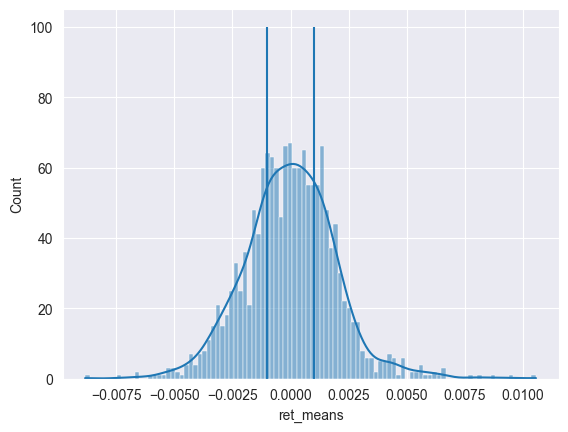

In [94]:
mu = dxy['ret_means'].mean()
sigma = dxy['ret_means'].std()
range_factor = 0.5
lb = mu - range_factor * sigma
ub = mu + range_factor * sigma
vol_bound = dxy['volatility'].quantile(0.7)

sns.histplot(dxy['ret_means'], bins=100, kde=True)
plt.vlines(x=[lb, ub], ymin=0, ymax=100)

In [95]:
conditions = [
    (dxy['ret_means'] >= ub) & (dxy['volatility'] < vol_bound),
    (dxy['ret_means'] >= ub) & (dxy['volatility'] >= vol_bound),
    (dxy['ret_means'] <= lb) & (dxy['volatility'] < vol_bound),
    (dxy['ret_means'] <= lb) & (dxy['volatility'] >= vol_bound),
]
dxy['regime'] = np.select(conditions, [1, 2, -1, -2], default=0)
dxy

Ticker,DX-Y.NYB,log_returns,ret_means,volatility,regime
Date,,,,,
2020-12-30,89.629997,-0.004231,-0.002263,0.001837,-1
2020-12-29,90.010002,-0.003659,-0.000067,0.004086,0
2020-12-28,90.339996,0.000111,0.000710,0.003569,0
2020-12-24,90.330002,-0.000885,0.001132,0.003605,1
2020-12-23,90.410004,-0.002651,-0.000088,0.005158,0
...,...,...,...,...,...
2015-01-15,92.349998,0.002059,-0.000043,0.003227,0
2015-01-14,92.160004,-0.001626,0.000587,0.003964,0
2015-01-13,92.309998,0.003581,0.001763,0.004015,1


<Axes: xlabel='Date', ylabel='log_returns'>

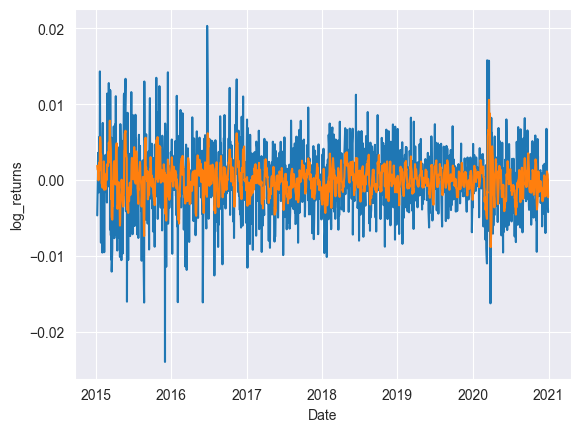

In [96]:
sns.lineplot(dxy['log_returns'])
sns.lineplot(dxy['ret_means'])

In [123]:
df = pd.read_csv('../../data/raw/currency/EURUSD=X.csv', delimiter=',', index_col='Date')
df_shifted = df.shift(1)
df['log_returns'] = np.log(df / df_shifted)
df['ret_means'] = df['log_returns'].rolling(5).mean()
df['volatility'] = df['log_returns'].rolling(5).std()
df['SMA_crossover'] = df['log_returns'].rolling(20).mean() - df['log_returns'].rolling(50).mean()
df = df[::-1].dropna()
df

,EURUSD=X,log_returns,ret_means,volatility,SMA_crossover
Date,,,,,
2020-12-30,0.816130,-0.002411,-0.001085,0.001165,-0.000031
2020-12-29,0.818100,-0.001502,0.000220,0.002356,-0.000423
2020-12-28,0.819330,-0.001671,0.000181,0.002393,-0.000148
2020-12-25,0.820700,0.000549,0.001276,0.002580,-0.000315
2020-12-24,0.820250,-0.000390,0.000134,0.003906,-0.000378
...,...,...,...,...,...
2020-03-17,0.895800,-0.000703,0.004162,0.003264,-0.001531
2020-03-16,0.896430,0.002647,0.004093,0.003394,-0.001438
2020-03-13,0.894060,0.006824,0.000695,0.009031,-0.001514


In [135]:
df = pd.read_csv('../../data/raw/currency/EURUSD=X.csv', delimiter=',', index_col='Date')
df['MACD'] = df['EURUSD=X'].ewm(span=12, adjust=False).mean() - df['EURUSD=X'].ewm(span=26, adjust=False).mean()
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_val'] = df['MACD'] - df['MACD_signal']
df = df[::-1]
df

,EURUSD=X,MACD,MACD_signal,MACD_val
Date,,,,
2020-12-30,0.816130,-0.005138,-0.005545,0.000407
2020-12-29,0.818100,-0.005143,-0.005647,0.000504
2020-12-28,0.819330,-0.005275,-0.005773,0.000498
2020-12-25,0.820700,-0.005492,-0.005898,0.000405
2020-12-24,0.820250,-0.005829,-0.005999,0.000170
...,...,...,...,...
2020-01-07,0.893017,0.000618,0.000263,0.000356
2020-01-06,0.895900,0.000618,0.000174,0.000444
2020-01-03,0.895140,0.000314,0.000063,0.000251


In [142]:
df = pd.read_csv('../../data/raw/currency/EURUSD=X.csv', delimiter=',', index_col='Date')
df = df[::-1]
df['RSI'] = momentum.rsi(df['EURUSD=X'], window=14)
df['MACD'] = trend.macd(df['EURUSD=X'])
df.dropna(inplace=True)
df

,EURUSD=X,RSI,MACD
Date,,,
2020-02-24,0.922590,65.271178,0.004170
2020-02-21,0.926956,67.721198,0.005267
2020-02-20,0.925061,65.559282,0.005915
2020-02-19,0.926320,66.328413,0.006456
2020-02-18,0.922500,61.817840,0.006502
2020-02-17,0.922360,61.652395,0.006452
2020-02-14,0.922000,61.198763,0.006311
2020-02-13,0.919460,57.958369,0.005926
2020-02-12,0.915800,53.557779,0.005265


<Axes: xlabel='Date', ylabel='RSI'>

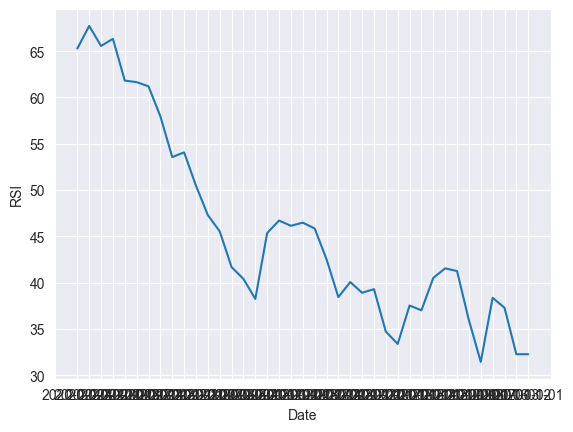

In [143]:
sns.lineplot(df['RSI'])

<Axes: xlabel='Date', ylabel='EURUSD=X'>

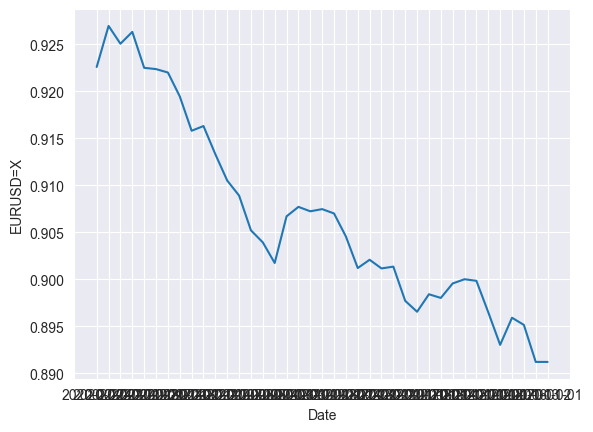

In [144]:
sns.lineplot(df['EURUSD=X'])

In [146]:
df.iloc[:,0]

Date
2020-02-24    0.922590
2020-02-21    0.926956
2020-02-20    0.925061
2020-02-19    0.926320
2020-02-18    0.922500
2020-02-17    0.922360
2020-02-14    0.922000
2020-02-13    0.919460
2020-02-12    0.915800
2020-02-11    0.916300
2020-02-10    0.913300
2020-02-07    0.910500
2020-02-06    0.908900
2020-02-05    0.905200
2020-02-04    0.903920
2020-02-03    0.901730
2020-01-31    0.906690
2020-01-30    0.907700
2020-01-29    0.907230
2020-01-28    0.907460
2020-01-27    0.907000
2020-01-24    0.904550
2020-01-23    0.901190
2020-01-22    0.902070
2020-01-21    0.901150
2020-01-20    0.901340
2020-01-17    0.897700
2020-01-16    0.896539
2020-01-15    0.898400
2020-01-14    0.898010
2020-01-13    0.899550
2020-01-10    0.900000
2020-01-09    0.899830
2020-01-08    0.896480
2020-01-07    0.893017
2020-01-06    0.895900
2020-01-03    0.895140
2020-01-02    0.891200
2020-01-01    0.891200
Name: EURUSD=X, dtype: float64

In [2]:
import os

In [32]:
dataframes = {}

for file in os.listdir('../../data/processed/currency'):
    ticker = file.split('.csv')[0]
    curr_df = pd.read_csv(f'../../data/processed/currency/{file}', delimiter=',', index_col='Date')
    dataframes[ticker] = curr_df
dataframes

{'GBPUSD=X':                   RSI      MACD  quad_var
 Date                                     
 2020-03-30  47.528386 -0.016073  0.001085
 2020-03-27  54.256272 -0.019716  0.000813
 2020-03-26  67.075773 -0.022388  0.000321
 2020-03-25  69.754131 -0.023010  0.000399
 2020-03-24  79.806741 -0.023040  0.001433
 2020-03-23  79.415687 -0.021279  0.001524
 2020-03-20  86.782319 -0.018930  0.001508
 2020-03-19  85.512405 -0.014676  0.001532
 2020-03-18  78.675136 -0.010030  0.000528
 2020-03-17  75.730894 -0.007541  0.000464
 2020-03-16  72.571542 -0.005247  0.000483
 2020-03-13  67.699788 -0.003135  0.000366
 2020-03-12  57.929837 -0.001506  0.000206
 2020-03-11  53.207442 -0.000972  0.000196
 2020-03-10  42.592517 -0.000839  0.000110
 2020-03-09  40.813248 -0.001657  0.000119
 2020-03-06  49.777024 -0.002818  0.000048
 2020-03-05  55.660088 -0.003368  0.000052
 2020-03-04  60.453301 -0.003559  0.000042
 2020-03-03  65.707508 -0.003416  0.000065
 2020-03-02  63.517199 -0.002850  0.000080

In [33]:
# Step 1: concatenate all DataFrames along columns
big_df = pd.concat(dataframes, axis=1)  # MultiIndex columns (currency, indicator)

# Step 2: drop rows (dates) with any missing value
big_df = big_df.dropna()

# Step 3: build a per-date dictionary of DataFrames
per_date_dfs = {
    date: big_df.loc[date].unstack()   # unstack turns MultiIndex into rows=indicators, cols=currencies
    for date in big_df.index
}
per_date_dfs['2020-03-27']

,RSI,MACD,quad_var
GBPUSD=X,54.256272,-0.019716,0.000813
JPY=X,52.000029,-0.465552,3.400898
MXN=X,61.850223,-1.322170,1.843098
SGD=X,59.691394,-0.016857,0.000463
EURUSD=X,47.087908,-0.003799,0.000276
CNY=X,57.990296,-0.029768,0.005155
AUDUSD=X,58.084205,-0.050068,0.004754
INR=X,53.097086,-0.943750,4.604787
NZDUSD=X,55.135050,-0.041239,0.004318
HKD=X,32.410164,0.005869,0.000018


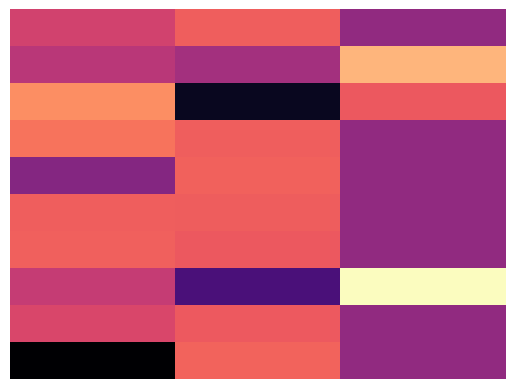

In [40]:
df = per_date_dfs['2020-03-27']
# Plot heatmap
# Normalize each column separately (min-max scaling per column)
df_norm = df.copy()
for col in df.columns:
    col_mean = df[col].mean()
    col_std = df[col].std()
    df_norm[col] = (df[col] - col_mean) / col_std

# Plot heatmap with normalized values
# Plot clean heatmap
plt.axis("off")  # remove axes
plt.imshow(df_norm.values, cmap="magma", aspect="auto")
plt.savefig("heatmap.png", bbox_inches="tight", pad_inches=0, dpi=1080)  # no whitespace
# plt.show()

<Axes: >

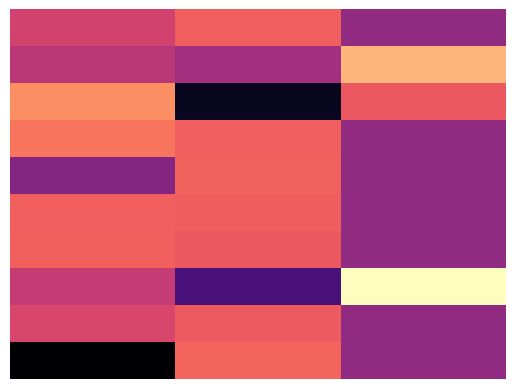

In [39]:
plt.axis("off")
sns.heatmap(df_norm, cmap="magma", annot=False, cbar=False)

In [23]:
df = pd.read_csv('../../data/raw/currency/EURUSD=X.csv')
df

,Date,EURUSD=X
0,2020-01-01,0.891200
1,2020-01-02,0.891200
2,2020-01-03,0.895140
3,2020-01-06,0.895900
4,2020-01-07,0.893017
...,...,...
59,2020-03-24,0.928970
60,2020-03-25,0.925700
61,2020-03-26,0.918310
62,2020-03-27,0.905120


In [24]:
def qv(window):
    diffs = np.diff(window)
    return sum(diffs**2)

df['QV'] = df['EURUSD=X'].rolling(3).apply(lambda x: sum(np.diff(x) ** 2), raw=True)
df

,Date,EURUSD=X,QV
0,2020-01-01,0.891200,NaN
1,2020-01-02,0.891200,NaN
2,2020-01-03,0.895140,0.000016
3,2020-01-06,0.895900,0.000016
4,2020-01-07,0.893017,0.000009
...,...,...,...
59,2020-03-24,0.928970,0.000048
60,2020-03-25,0.925700,0.000048
61,2020-03-26,0.918310,0.000065
62,2020-03-27,0.905120,0.000229


In [43]:
yf.download('ROMAIN')

/var/folders/7h/v_m4v2857ls7fgyxr51v7j2h0000gn/T/ipykernel_13470/2729890710.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download('ROMAIN')
HTTP Error 404: 
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ROMAIN']: YFPricesMissingError('possibly delisted; no price data found  (period=1mo) (Yahoo error = "No data found, symbol may be delisted")')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ROMAIN,ROMAIN,ROMAIN,ROMAIN,ROMAIN,ROMAIN
Date,,,,,,
